# 유튜브 댓글 감정분석
reference : https://cyc1am3n.github.io/2018/11/10/classifying_korean_movie_review.html

In [ ]:
#나눔고딕 폰트 설치
#한번 실행 후 런타임 재시작 필요
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 0s (50.4 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 121913 files and direc

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def read_data(filename):
    with open(filename, 'r') as f:
        data = [line.split('\t') for line in f.read().splitlines()]
        # txt 파일의 헤더(id document label)는 제외하기
        data = data[1:]
    return data

#경로설정 필요
train_data = read_data('/content/drive/MyDrive/대학자료/대4/4학년 2학기/국어정보학/기말보고서/data/model/ratings_train.txt')
test_data = read_data('/content/drive/MyDrive/대학자료/대4/4학년 2학기/국어정보학/기말보고서/data/model/ratings_test.txt')

In [ ]:
print(len(train_data))
print(len(train_data[0]))
print(len(test_data))
print(len(test_data[0]))

150000
3
50000
3


In [ ]:
train_data[:5]

[['9976970', '아 더빙.. 진짜 짜증나네요 목소리', '0'],
 ['3819312', '흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나', '1'],
 ['10265843', '너무재밓었다그래서보는것을추천한다', '0'],
 ['9045019', '교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정', '0'],
 ['6483659',
  '사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다',
  '1']]

In [ ]:
test_data[:5]

[['6270596', '굳 ㅋ', '1'],
 ['9274899', 'GDNTOPCLASSINTHECLUB', '0'],
 ['8544678', '뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아', '0'],
 ['6825595', '지루하지는 않은데 완전 막장임... 돈주고 보기에는....', '0'],
 ['6723715', '3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??', '0']]

 ## KoNLPy 라이브러리를 이용해서 형태소 분석 및 품사 태깅

In [ ]:
!pip install konlpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 67.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 51.4 MB/s eta 0:00:00


In [ ]:
import konlpy

konlpy.__version__

'0.6.0'

In [ ]:
# 한글과 공백을 제외한 모든 요소 제거

import re

# 한글과 공백을 제외한 모든 문자를 제거하는 함수
def clean_text(text):
    return re.sub(r"[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", text)

train_data_cleaned = [[entry[0], clean_text(entry[1]), entry[2]] for entry in train_data]
test_data_cleaned = [[entry[0], clean_text(entry[1]), entry[2]] for entry in test_data]

print(train_data_cleaned[:5])
print(test_data_cleaned[:5])

[['9976970', '아 더빙 진짜 짜증나네요 목소리', '0'], ['3819312', '흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나', '1'], ['10265843', '너무재밓었다그래서보는것을추천한다', '0'], ['9045019', '교도소 이야기구먼 솔직히 재미는 없다평점 조정', '0'], ['6483659', '사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다', '1']]
[['6270596', '굳 ㅋ', '1'], ['9274899', '', '0'], ['8544678', '뭐야 이 평점들은 나쁘진 않지만 점 짜리는 더더욱 아니잖아', '0'], ['6825595', '지루하지는 않은데 완전 막장임 돈주고 보기에는', '0'], ['6723715', '만 아니었어도 별 다섯 개 줬을텐데 왜 로 나와서 제 심기를 불편하게 하죠', '0']]


In [ ]:
#Okt를 활용한 문장 분석 (품사 태깅)
from konlpy.tag import Okt

okt = Okt()
print(okt.pos(u'이 밤 그날의 반딧불을 당신의 창 가까이 보낼게요'))

[('이', 'Noun'), ('밤', 'Noun'), ('그날', 'Noun'), ('의', 'Josa'), ('반딧불', 'Noun'), ('을', 'Josa'), ('당신', 'Noun'), ('의', 'Josa'), ('창', 'Noun'), ('가까이', 'Noun'), ('보낼게요', 'Verb')]


In [ ]:
import json
import os
from pprint import pprint
from tqdm import tqdm

def tokenize(doc):
    # norm은 정규화, stem은 근어로 표시하기를 나타냄
    return ['/'.join(t) for t in okt.pos(doc, norm=True, stem=True)]

if os.path.isfile('/content/drive/MyDrive/대학자료/대4/4학년 2학기/국어정보학/기말보고서/data/model/train_docs.json'):
    with open('/content/drive/MyDrive/대학자료/대4/4학년 2학기/국어정보학/기말보고서/data/model/train_docs.json') as f:
        train_docs = json.load(f)
    with open('/content/drive/MyDrive/대학자료/대4/4학년 2학기/국어정보학/기말보고서/data/model/test_docs.json') as f:
        test_docs = json.load(f)
else:
    train_docs = []
    for row in tqdm(train_data):
        train_docs.append((tokenize(row[1]), row[2]))

    test_docs = []
    for row in tqdm(test_data):
        test_docs.append((tokenize(row[1]), row[2]))

    # JSON 파일로 저장
    with open('/content/drive/MyDrive/대학자료/대4/4학년 2학기/국어정보학/기말보고서/data/model/train_docs.json', 'w', encoding="utf-8") as make_file:
        json.dump(train_docs, make_file, ensure_ascii=False, indent="\t")
    with open('/content/drive/MyDrive/대학자료/대4/4학년 2학기/국어정보학/기말보고서/data/model/test_docs.json', 'w', encoding="utf-8") as make_file:
        json.dump(test_docs, make_file, ensure_ascii=False, indent="\t")

# 예쁘게(?) 출력하기 위해서 pprint 라이브러리 사용
pprint(train_docs[0])


[['아/Exclamation',
  '더빙/Noun',
  '../Punctuation',
  '진짜/Noun',
  '짜증나다/Adjective',
  '목소리/Noun'],
 '0']


In [ ]:
tokens = [t for d in train_docs for t in d[0]]
print(len(tokens))

2159921


In [ ]:
import nltk
text = nltk.Text(tokens, name='NMSC')
print(text)

<Text: NMSC>


In [ ]:
# 전체 토큰의 개수
print(len(text.tokens))

# 중복을 제외한 토큰의 개수
print(len(set(text.tokens)))

# 출현 빈도가 높은 상위 토큰 10개
pprint(text.vocab().most_common(10))

2159921
49895
[('./Punctuation', 67778),
 ('영화/Noun', 50818),
 ('하다/Verb', 41209),
 ('이/Josa', 38540),
 ('보다/Verb', 38538),
 ('의/Josa', 30188),
 ('../Punctuation', 29055),
 ('가/Josa', 26627),
 ('에/Josa', 26468),
 ('을/Josa', 23118)]


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50689 (\N{HANGUL SYLLABLE YEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54616 (\N{HANGUL SYLLABLE HA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45796 (\N{HANGUL SYLLABLE DA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IP

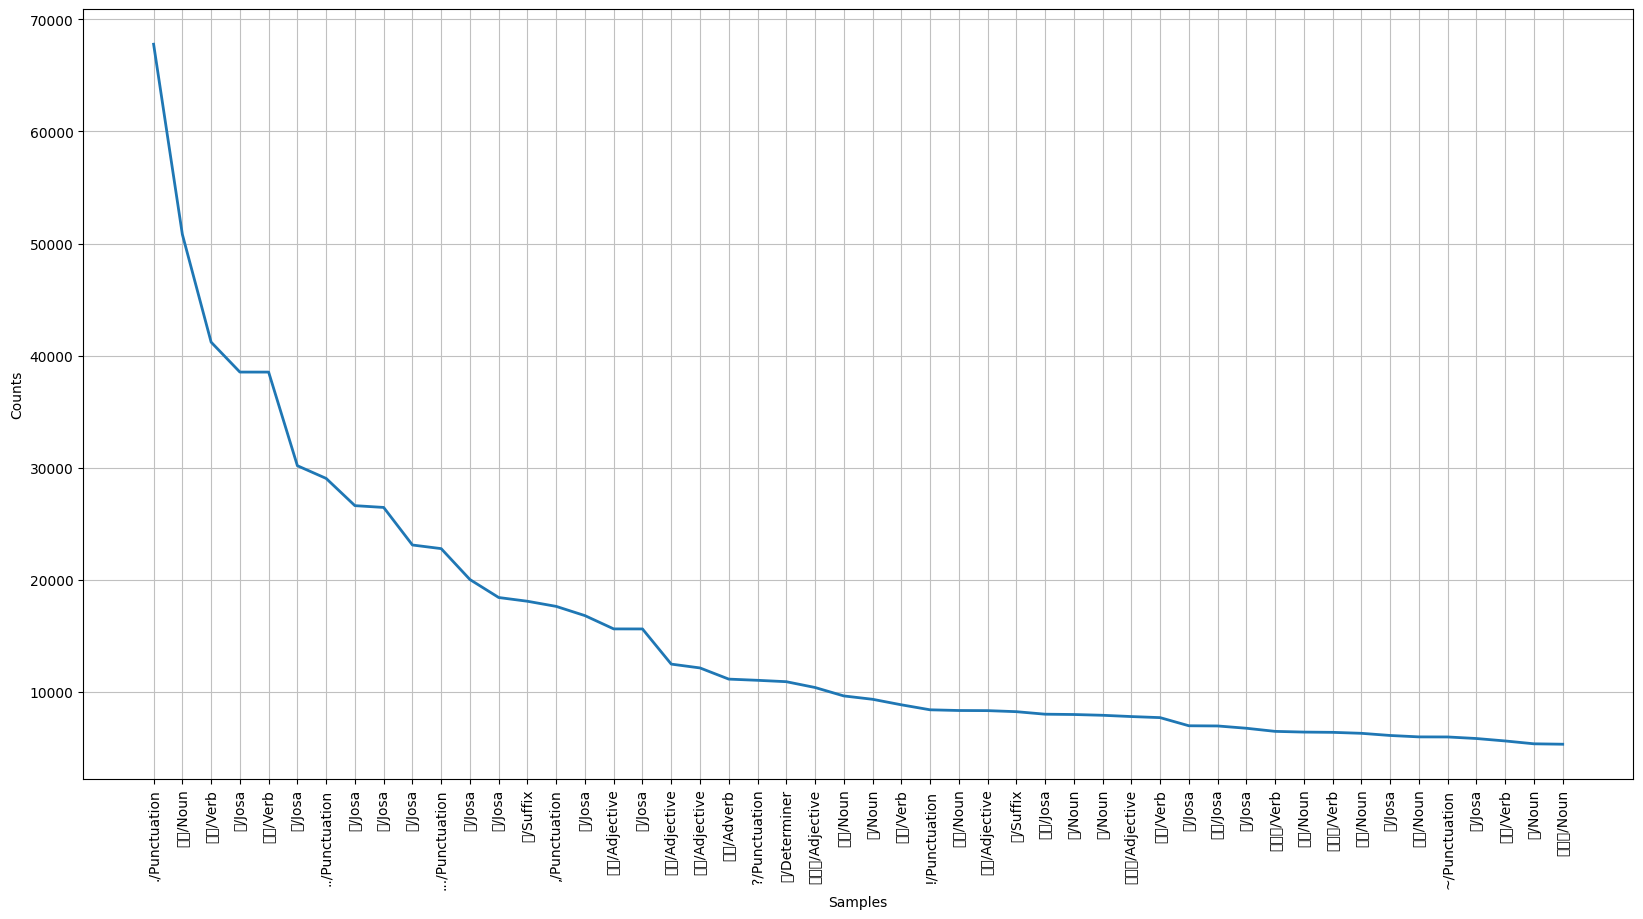

<Axes: xlabel='Samples', ylabel='Counts'>

In [ ]:
#데이터 빈도 시각화
import matplotlib.pyplot as plt
plt.rc('font', family='NanumGothic')

plt.figure(figsize=(20, 10))
text.plot(50)

In [ ]:
from tqdm import tqdm
import os
import numpy as np

selected_words = [f[0] for f in text.vocab().most_common(5000)]

def term_frequency(doc):
    return [doc.count(word) for word in selected_words]

train_x_path = '/content/drive/MyDrive/대학자료/대4/4학년 2학기/국어정보학/기말보고서/data/model/train_x.npy'
test_x_path = '/content/drive/MyDrive/대학자료/대4/4학년 2학기/국어정보학/기말보고서/data/model/test_x.npy'
train_y_path = '/content/drive/MyDrive/대학자료/대4/4학년 2학기/국어정보학/기말보고서/data/model/train_y.npy'
test_y_path = '/content/drive/MyDrive/대학자료/대4/4학년 2학기/국어정보학/기말보고서/data/model/test_y.npy'

if os.path.isfile(train_x_path) and os.path.isfile(test_x_path) and os.path.isfile(train_y_path) and os.path.isfile(test_y_path):
    train_x = np.load(train_x_path)
    test_x = np.load(test_x_path)
    train_y = np.load(train_y_path)
    test_y = np.load(test_y_path)
else:
    train_x = []
    for d, _ in tqdm(train_docs):
        train_x.append(term_frequency(d))

    test_x = []
    for d, _ in tqdm(test_docs):
        test_x.append(term_frequency(d))

    train_y = [c for _, c in train_docs]
    test_y = [c for _, c in test_docs]

    train_x = np.array(train_x)
    test_x = np.array(test_x)
    train_y = np.array(train_y)
    test_y = np.array(test_y)

    # Save the vectorized data
    np.save(train_x_path, train_x)
    np.save(test_x_path, test_x)
    np.save(train_y_path, train_y)
    np.save(test_y_path, test_y)


In [ ]:
# 데이터를 float형으로 변환
import numpy as np

x_train = np.asarray(train_x).astype('float32')
x_test = np.asarray(test_x).astype('float32')

y_train = np.asarray(train_y).astype('float32')
y_test = np.asarray(test_y).astype('float32')

## 모델 정의 및 학습하기

Dense 층은 64개의 유닛을 가지고 활성화 함수로는 relu를 사용했으며, 마지막 층은 sigmoid 활성화 함수를 사용해서 긍정의 리뷰일 확률을 출력함

손실 함수로는 binary_crossentropy를 사용했고 RMSProp 옵티마이저를 통해서 경사하강법을 진행

배치 사이즈를 512로, 에포크를 10번으로 학습 (추후 fine tuning 필요)

In [ ]:
!pip install tensorflow

In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(5000,))) #입력벡터에 맞게 수정
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
             loss=losses.binary_crossentropy,
             metrics=[metrics.binary_accuracy])

model.fit(x_train, y_train, epochs=10, batch_size=512)
results = model.evaluate(x_test, y_test)

Epoch 1/10
293/293 [==============================] - 5s 8ms/step - loss: 0.4122 - binary_accuracy: 0.8183
Epoch 2/10
293/293 [==============================] - 2s 6ms/step - loss: 0.3344 - binary_accuracy: 0.8543
Epoch 3/10
293/293 [==============================] - 2s 6ms/step - loss: 0.3082 - binary_accuracy: 0.8674
Epoch 4/10
293/293 [==============================] - 2s 6ms/step - loss: 0.2843 - binary_accuracy: 0.8803
Epoch 5/10
293/293 [==============================] - 2s 7ms/step - loss: 0.2609 - binary_accuracy: 0.8931
Epoch 6/10
293/293 [==============================] - 2s 6ms/step - loss: 0.2380 - binary_accuracy: 0.9043
Epoch 7/10
293/293 [==============================] - 2s 6ms/step - loss: 0.2154 - binary_accuracy: 0.9149
Epoch 8/10
293/293 [==============================] - 2s 6ms/step - loss: 0.1935 - binary_accuracy: 0.9255
Epoch 9/10
293/293 [==============================] - 2s 6ms/step - loss: 0.1734 - binary_accuracy: 0.9340
Epoch 10/10
1563/1563 [==============

In [ ]:
results #성능확인

[0.44158753752708435, 0.8481600284576416]

## 새로운 데이터로 결과 예측하기

###예제

In [ ]:
def predict_pos_neg(review):
    token = tokenize(review)
    if token is None:
        return 0.5  # 기본적으로 중립적인 감정으로 가정
    tf = term_frequency(token)
    data = np.expand_dims(np.asarray(tf).astype('float32'), axis=0)
    score = float(model.predict(data, verbose=0))  # verbose 매개변수를 0으로 설정

    # if score > 0.5:
    #     print("[{}]는 {:.2f}% 확률로 긍정 리뷰이지 않을까 추측해봅니다.^^\n".format(review, score * 100))
    # else:
    #     print("[{}]는 {:.2f}% 확률로 부정 리뷰이지 않을까 추측해봅니다.^^;\n".format(review, (1 - score) * 100))

    return score

In [ ]:
predict_pos_neg("올해 최고의 영화! 세 번 넘게 봐도 질리지가 않네요.")
predict_pos_neg("배경 음악이 영화의 분위기랑 너무 안 맞았습니다. 몰입에 방해가 됩니다.")
predict_pos_neg("주연 배우가 신인인데 연기를 진짜 잘 하네요. 몰입감 ㅎㄷㄷ")
predict_pos_neg("믿고 보는 감독이지만 이번에는 아니네요")
predict_pos_neg("주연배우 때문에 봤어요")

<ipython-input-22-5cdaf90ceda9>:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(model.predict(data, verbose=0))  # verbose 매개변수를 0으로 설정


0.1664665788412094

In [ ]:
predict_pos_neg("배경 음악이 영화의 분위기랑 너무 안 맞았습니다. 몰입에 방해가 됩니다.")

<ipython-input-22-5cdaf90ceda9>:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(model.predict(data, verbose=0))  # verbose 매개변수를 0으로 설정


0.0780714750289917

### 유튜브 댓글 크롤링 데이터 감정분석

label : 긍정은 0, 부정은 1

percent : 각 긍정/부정 퍼센테이지



In [ ]:
import pandas as pd

crawling_data = pd.read_csv('/content/drive/MyDrive/대학자료/대4/4학년 2학기/국어정보학/기말보고서/data/youtube_chatgpt_news_comments_cleaned.csv')

In [ ]:
crawling_data

,contentText
0,드디어 영화 Her가 현실이 되었네 음색 옵션에 스칼렛 요한슨 음성으로가 있으면 좋겠다
1,진짜 헐Her이다
2,실제로 샘알트먼이 그렇게 슬쩍 하려다가 걸려서 스칼렛 법률팀한테 지금 고소당하기 직...
3,근데 하나도 안비슷하긴 하더라 걍 다른 성우던데
4,별로
...,...
5857,싱글 3000 하고 2200이 비슷한거야
5858,팩트 삼성은 자체 칩도 못 만들어서 남의 칩 쓴다
5859,맞는말이긴함 근데 팩트는 애플ai칩못만든다는거 시대에 뒤쳐짐
5860,시리 싸가지 없이 말대꾸만 많이 하고 있지 ㅋ


In [ ]:
#공백 검사
missing_values = crawling_data['contentText'].isna() | (crawling_data['contentText'] == '')
missing_rows = crawling_data[missing_values]

if not missing_rows.empty:
    print("Missing or empty values found in 'contentText' column:")
    print(missing_rows)
else:
    print("No missing or empty values found in 'contentText' column.")

No missing or empty values found in 'contentText' column.


In [ ]:
len(crawling_data)

5862

In [ ]:
!pip install --upgrade tqdm

In [ ]:
# 감정분석 결과를 기반으로 label과 percent 열을 추가하는 함수
def analyze_sentiment(row):
    content = row['contentText']
    score = predict_pos_neg(content)

    if score >= 0.5:
        label = 1  # 긍정적인 감정으로 분류
        percent = score * 100
    else:
        label = 0  # 부정적인 감정으로 분류
        percent = (1 - score) * 100

    return pd.Series([content, label, percent], index=['contentText', 'label', 'percent'])

In [ ]:
# 상위 10개 항목만 선택하여 analyze_sentiment 함수를 적용한 데이터프레임 생성
crawling_data_sample = pd.DataFrame(columns=['contentText', 'label', 'percent'])
for index, row in tqdm(crawling_data.head(10).iterrows(), total=10, ncols=70):
    analyzed_row = analyze_sentiment(row)
    crawling_data_sample = pd.concat([crawling_data_sample, pd.DataFrame([analyzed_row])], ignore_index=True)

crawling_data_sample

  0%|                                          | 0/10 [00:00<?, ?it/s]<ipython-input-22-5cdaf90ceda9>:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(model.predict(data, verbose=0))  # verbose 매개변수를 0으로 설정
100%|█████████████████████████████████| 10/10 [00:00<00:00, 13.15it/s]


,contentText,label,percent
0,드디어 영화 Her가 현실이 되었네 음색 옵션에 스칼렛 요한슨 음성으로가 있으면 좋겠다,1,98.137617
1,진짜 헐Her이다,0,80.212288
2,실제로 샘알트먼이 그렇게 슬쩍 하려다가 걸려서 스칼렛 법률팀한테 지금 고소당하기 직...,0,59.430099
3,근데 하나도 안비슷하긴 하더라 걍 다른 성우던데,0,97.026804
4,별로,0,98.346850
5,미국 자비스 만듬한국 성형외과 미용 수술함미국 chatgpt gemini LLM등 ...,0,89.362665
6,저긴 AI 법 제정하네 마네 하는데 우리는 여성 할당제 시행하네 폐지하네 이딴 걸로...,0,97.357424
7,심지어 중국 최상위권 입시 준비반 인공지능학과한국 최상위권 입시 준비반 의대 진학반...,1,61.783832
8,팩트는 어차피 특이점 와서 나라 망하든 말든 상관없다는거임ㅋㅋㅋㅋㅋ,0,58.036783
9,미국한테 못비비지,0,85.200807


In [ ]:
# 감정분석을 수행하고 결과를 추가한 새로운 데이터프레임 생성
crawling_data_with_sentiment = pd.DataFrame(columns=['contentText', 'label', 'percent'])

# tqdm을 사용하여 진행 상황 표시
for index, row in tqdm(crawling_data.iterrows(), total=len(crawling_data), ncols=70):
    analyzed_row = analyze_sentiment(row)
    crawling_data_with_sentiment = pd.concat([crawling_data_with_sentiment, pd.DataFrame([analyzed_row])], ignore_index=True)

print(crawling_data_with_sentiment)

  0%|                                        | 0/5862 [00:00<?, ?it/s]<ipython-input-22-5cdaf90ceda9>:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(model.predict(data, verbose=0))  # verbose 매개변수를 0으로 설정
100%|█████████████████████████████| 5862/5862 [07:44<00:00, 12.61it/s]

                                            contentText label    percent
0      드디어 영화 Her가 현실이 되었네 음색 옵션에 스칼렛 요한슨 음성으로가 있으면 좋겠다     1  98.137617
1                                             진짜 헐Her이다     0  80.212288
2     실제로 샘알트먼이 그렇게 슬쩍 하려다가 걸려서 스칼렛 법률팀한테 지금 고소당하기 직...     0  59.430099
3                            근데 하나도 안비슷하긴 하더라 걍 다른 성우던데     0  97.026804
4                                                    별로     0  98.346850
...                                                 ...   ...        ...
5857                            싱글 3000 하고 2200이 비슷한거야      1  51.613116
5858                        팩트 삼성은 자체 칩도 못 만들어서 남의 칩 쓴다     0  98.944172
5859                  맞는말이긴함 근데 팩트는 애플ai칩못만든다는거 시대에 뒤쳐짐     1  91.947895
5860                          시리 싸가지 없이 말대꾸만 많이 하고 있지 ㅋ     0  92.889279
5861                               KBS는 이제 그냥 바보방송국 된거임     1  65.716636

[5862 rows x 3 columns]


In [ ]:
crawling_data_with_sentiment.head(10)

,contentText,label,percent
0,드디어 영화 Her가 현실이 되었네 음색 옵션에 스칼렛 요한슨 음성으로가 있으면 좋겠다,1,98.137617
1,진짜 헐Her이다,0,80.212288
2,실제로 샘알트먼이 그렇게 슬쩍 하려다가 걸려서 스칼렛 법률팀한테 지금 고소당하기 직...,0,59.430099
3,근데 하나도 안비슷하긴 하더라 걍 다른 성우던데,0,97.026804
4,별로,0,98.346850
5,미국 자비스 만듬한국 성형외과 미용 수술함미국 chatgpt gemini LLM등 ...,0,89.362665
6,저긴 AI 법 제정하네 마네 하는데 우리는 여성 할당제 시행하네 폐지하네 이딴 걸로...,0,97.357424
7,심지어 중국 최상위권 입시 준비반 인공지능학과한국 최상위권 입시 준비반 의대 진학반...,1,61.783832
8,팩트는 어차피 특이점 와서 나라 망하든 말든 상관없다는거임ㅋㅋㅋㅋㅋ,0,58.036783
9,미국한테 못비비지,0,85.200807


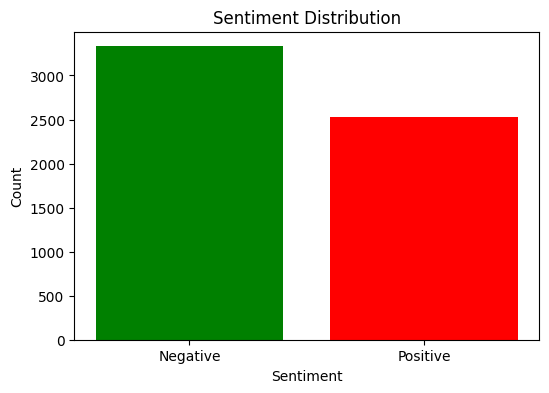

In [ ]:
import matplotlib.pyplot as plt

# 레이블 값 매핑
label_mapping = {1: 'Positive', 0: 'Negative'}

# label 열 값에 대한 카운트 계산
label_counts = crawling_data_with_sentiment['label'].map(label_mapping).value_counts()

# 그래프 생성
plt.figure(figsize=(6, 4))
colors = ['green', 'red']  # 막대 색상
plt.bar(label_counts.index, label_counts.values, color=colors)

# 그래프 레이블 설정
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution')

# 그래프 출력
plt.show()


In [ ]:
#csv 파일로 저장
crawling_data_with_sentiment.to_csv('/content/drive/MyDrive/대학자료/대4/4학년 2학기/국어정보학/기말보고서/data/youtube_chatgpt_news_comments_with_sentiment.csv', index=False)